# Train Deep Q-Network

### 1. Install and import the Necessary Packages

In [1]:
# !pip install gym
# !pip install gym[box2d]
# !pip install gym[classic_control]
# !pip -q install ./python

In [2]:
from pathlib import Path
from collections import deque

import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from bananas.bananas_agent.dqn_agent import Agent

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [3]:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
BRAIN_NAME = env.brain_names[0]
brain = env.brains[BRAIN_NAME]

env_info = env.reset(train_mode=True)[BRAIN_NAME]
state = env_info.vector_observations[0]
ACTION_SIZE = brain.vector_action_space_size
STATE_SIZE = len(state)

In [5]:
agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE)

### 3. Train the Agent with DQN

In [6]:
# setup train parameters
n_episodes = 2000
max_steps = 2000
eps_max = 1.
eps_min = 0.01
min_expected_score = -3
target_score = 13
warm_start = False

In [7]:
# warm start
CHECKPOINT_PATH = Path('bananas/checkpoints/checkpoint.pth')
if warm_start and CHECKPOINT_PATH.is_file():
    print("Using warm start!")
    agent.qnetwork_local.load_state_dict(torch.load(CHECKPOINT_PATH))
    agent.update_target_model()

In [8]:
def run_episode(env, epsilon, max_steps):
    """ Run a single episode. """
    state = env.reset(train_mode=True)[BRAIN_NAME].vector_observations[0]
    score = 0
    for t in range(max_steps):
        action = agent.act(state, epsilon)
        env_info = env.step(action)[BRAIN_NAME]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score

def epsilon_interpolator(current_score):
    """ Update epsilon with a log interpolation based on average score. """
    eps_max_log, eps_min_log = np.log(eps_max), np.log(eps_min)
    return np.e ** np.interp(
        current_score,
        xp=[min_expected_score, target_score],
        fp=[eps_max_log, eps_min_log],
        left=eps_max_log,
        right=eps_min_log,
    )

scores = []
# compute average score based on last 100 scores
scores_window = deque(maxlen=100)

In [9]:
epsilon = eps_max
for i_episode in range(1, n_episodes + 1):
    score = run_episode(env, epsilon, max_steps)
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    average_score = np.mean(scores_window)
    epsilon = epsilon_interpolator(average_score)
    print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, average_score, epsilon), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, average_score, epsilon))
    if average_score >= target_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break

Episode 100	Average Score: 3.65	Epsilon: 0.15
Episode 200	Average Score: 7.70	Epsilon: 0.05
Episode 300	Average Score: 10.40	Epsilon: 0.02
Episode 400	Average Score: 10.90	Epsilon: 0.02
Episode 500	Average Score: 11.11	Epsilon: 0.02
Episode 600	Average Score: 12.66	Epsilon: 0.01
Episode 616	Average Score: 13.09	Epsilon: 0.01
Environment solved in 516 episodes!	Average Score: 13.09


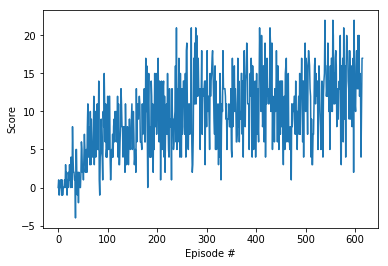

In [10]:
# plot the score evolution
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('score_evolution.png')

In [11]:
torch.save(agent.qnetwork_local.state_dict(), CHECKPOINT_PATH)